# Microsoft 365 User Analytics: Data Preparation and EDA

In this notebook, we perform data preparation, cleaning, feature engineering, and exploratory data analysis (EDA) on user activity data to gain insights into engagement patterns in Microsoft 365 applications.

First 5 rows of the dataset:


,fullVisitorId,visitStartTime,date,deviceCategory,isMobile,operatingSystem,browser,country,city,trafficSource,trafficMedium,trafficCampaign,isFirstVisit,totalVisits,totalHits,totalPageviews,totalTimeOnSite,productPagesViewed,addedToCart
0,4214259466202417480,1476492957,2016-10-14 00:00:00+00:00,desktop,False,Windows,Internet Explorer,United States,not available in demo dataset,ask,organic,(not set),0,1.0,2.0,2.0,16.0,0.0,0.0
1,3541738396641160713,1493611205,2017-04-30 00:00:00+00:00,desktop,False,Windows,Chrome,United States,not available in demo dataset,ask,organic,(not set),0,1.0,1.0,1.0,0.0,0.0,0.0
2,8276557623242379934,1490071147,2017-03-20 00:00:00+00:00,desktop,False,Windows,Chrome,Australia,Brisbane,ask,organic,(not set),0,1.0,2.0,2.0,16.0,0.0,0.0
3,5855313117666192014,1491048053,2017-04-01 00:00:00+00:00,desktop,False,Windows,Chrome,Australia,Sydney,ask,organic,(not set),0,1.0,1.0,1.0,0.0,0.0,0.0
4,2619633492044211273,1495292376,2017-05-20 00:00:00+00:00,desktop,False,Windows,Chrome,United States,not available in demo dataset,ask,organic,(not set),0,1.0,15.0,12.0,326.0,1.0,1.0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748134 entries, 0 to 748133
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fullVisitorId       748134 non-null  object 
 1   visitStartTime      748134 non-null  int64  
 2   date                748134 non-null  object 
 3   deviceCategory      748134 non-null  object 
 4   isMobile            748134 non-null  bool   
 5   operatingSystem     748134 non-null  object 
 6   browser             748134 non-null  object 
 7   country             748134 non-null  object 
 8   city                748134 non-null  object 
 9   trafficSource       748134 non-null  object 
 10  trafficMedium       748134 non-null  object 
 11  trafficCampaign     748134 non-null  object 
 12  isFirstVisit        748134 non-null  int64  
 13  totalVisits         748133 non-null  float64
 14  totalHits           748133 non-null  float64
 15  totalPagevie

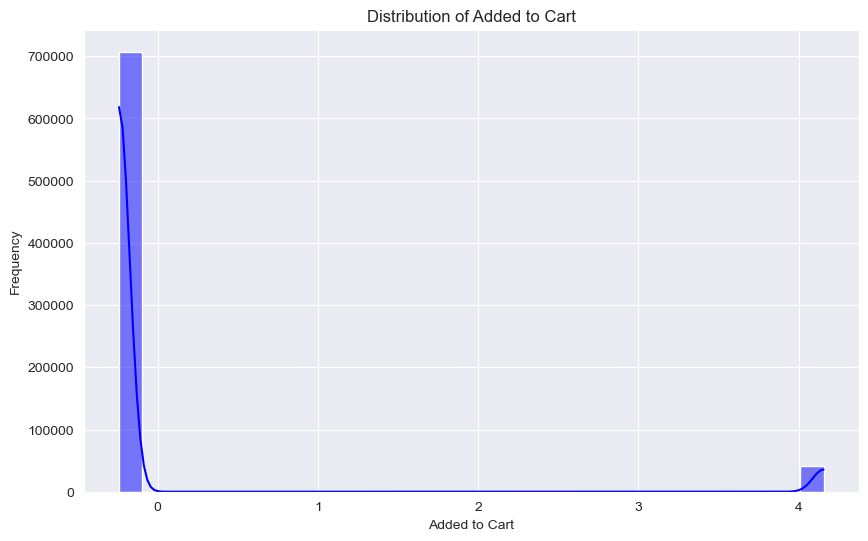

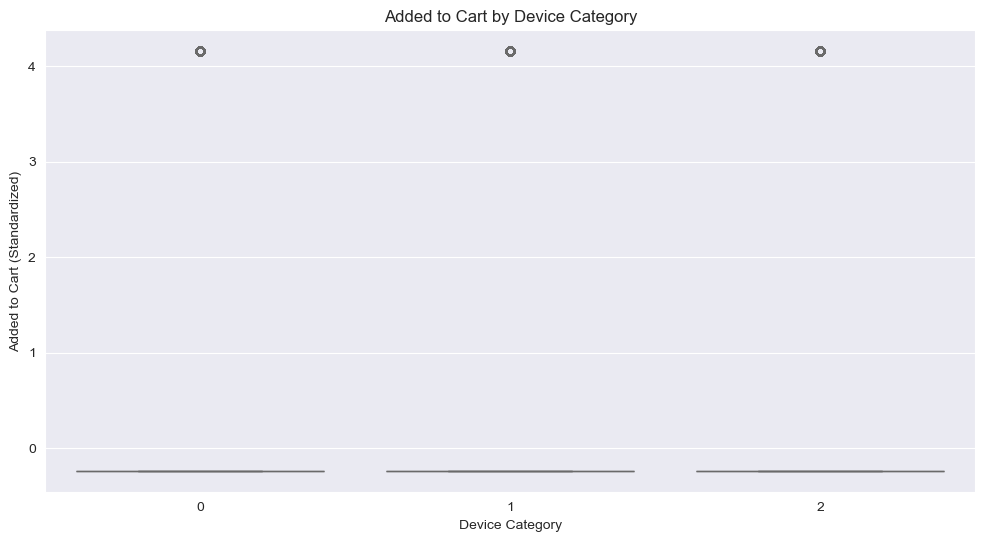

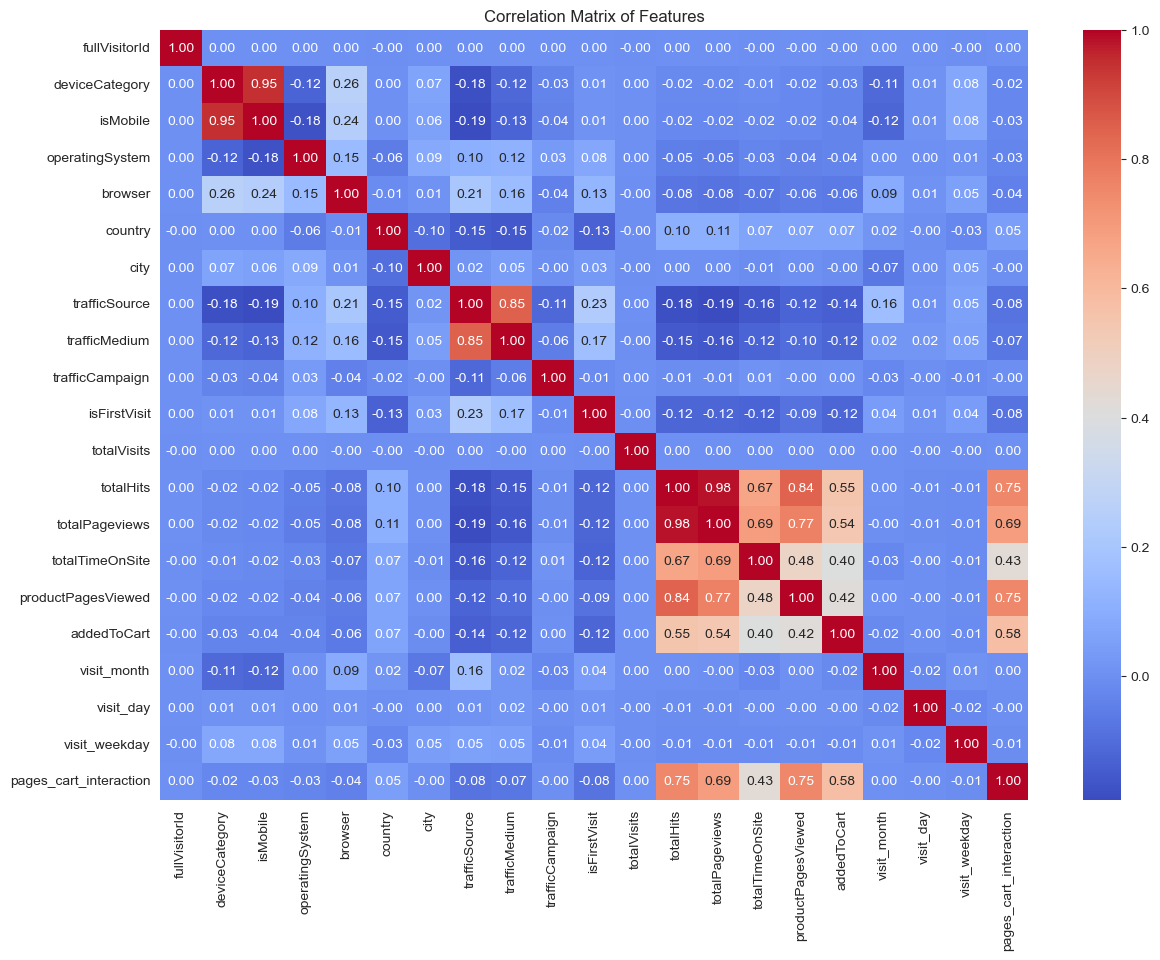

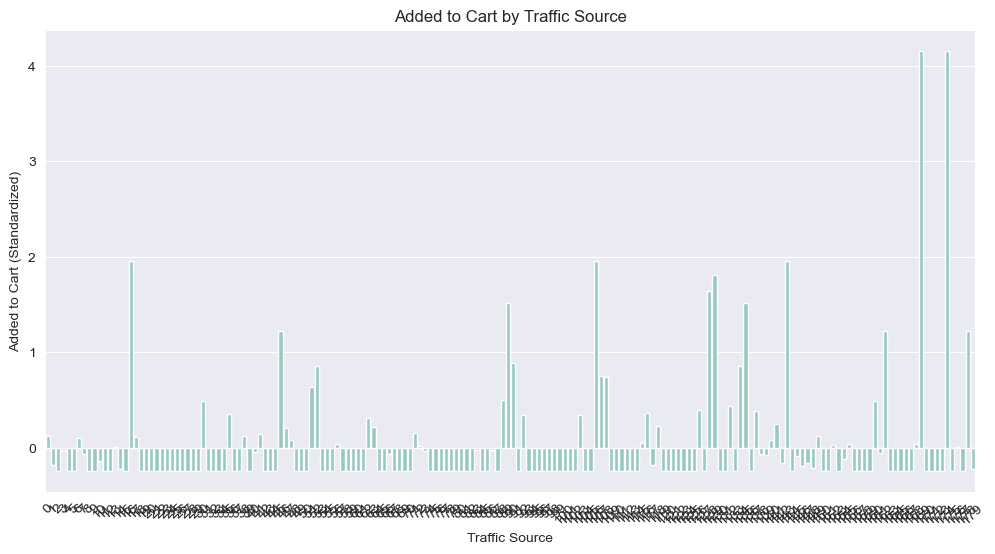


Preprocessed data saved successfully to data/preprocessed_microsoft365_user_activity.csv


In [6]:
# Microsoft 365 User Analytics: Data Preparation and Analysis

# Step 1: Setup

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use('dark_background')  # Replace 'seaborn-darkgrid' with 'dark_background' for matplotlib
sns.set_style("darkgrid")  # Seaborn's native style option


# Step 2: Load the Dataset

# Replace 'your_dataset.csv' with the actual path to your dataset file
data_path = 'data/user_activity.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
display(data.head())

# Step 3: Initial Data Inspection

# Check data types and missing values
print("\nDataset Information:")
print(data.info())

print("\nMissing Values in Each Column:")
print(data.isnull().sum())

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(data.describe())

# Step 4: Data Cleaning and Preprocessing

# 4.1: Handle Missing Values

# Identify numerical columns with missing values
numeric_columns = ['totalVisits', 'totalHits', 'totalPageviews', 
                   'totalTimeOnSite', 'productPagesViewed', 'addedToCart']

# Fill missing numerical values with 0 (or you can choose mean/median based on context)
data[numeric_columns] = data[numeric_columns].fillna(0)

# Verify that there are no missing values left
print("\nMissing Values After Imputation:")
print(data[numeric_columns].isnull().sum())

# 4.2: Encode Categorical Variables

# Identify categorical columns
categorical_columns = ['deviceCategory', 'operatingSystem', 'browser', 
                       'country', 'city', 'trafficSource', 'trafficMedium', 'trafficCampaign']

# Initialize LabelEncoders for each categorical column
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le  # Save encoders for future use if needed
    print(f"Encoded {column} with classes: {le.classes_}")

# 4.3: Convert 'isMobile' from boolean to integer
data['isMobile'] = data['isMobile'].astype(int)

# 4.4: Convert 'date' and 'visitStartTime' to datetime

# Assuming 'visitStartTime' is a Unix timestamp in seconds
data['visitStartTime'] = pd.to_datetime(data['visitStartTime'], unit='s')

# Convert 'date' to datetime, accounting for any time components
# Setting errors='coerce' ensures invalid formats are turned to NaT
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# 4.5: Feature Engineering

# Create new time-based features
data['visit_month'] = data['visitStartTime'].dt.month
data['visit_day'] = data['visitStartTime'].dt.day
data['visit_weekday'] = data['visitStartTime'].dt.weekday  # Monday=0, Sunday=6

# Create interaction feature between 'productPagesViewed' and 'addedToCart'
data['pages_cart_interaction'] = data['productPagesViewed'] * data['addedToCart']

# Drop original 'visitStartTime' and 'date' if they are not needed anymore
data = data.drop(['visitStartTime', 'date'], axis=1)

# 4.6: Feature Scaling

# Identify numerical columns for scaling
scaling_columns = ['totalVisits', 'totalHits', 'totalPageviews', 
                   'totalTimeOnSite', 'productPagesViewed', 'addedToCart',
                   'pages_cart_interaction']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the scaling columns
data[scaling_columns] = scaler.fit_transform(data[scaling_columns])

# Step 5: Exploratory Data Analysis (EDA)

# 5.1: Distribution of 'addedToCart'
plt.figure(figsize=(10, 6))
sns.histplot(data['addedToCart'], bins=30, kde=True, color='blue')
plt.title('Distribution of Added to Cart')
plt.xlabel('Added to Cart')
plt.ylabel('Frequency')
plt.show()

# 5.2: Purchase Distribution by Device Category
plt.figure(figsize=(12, 6))
sns.boxplot(x='deviceCategory', y='addedToCart', data=data)
plt.title('Added to Cart by Device Category')
plt.xlabel('Device Category')
plt.ylabel('Added to Cart (Standardized)')
plt.show()

# 5.3: Correlation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# 5.4: Purchase vs. Traffic Source
plt.figure(figsize=(12, 6))
sns.barplot(x='trafficSource', y='addedToCart', data=data, ci=None)
plt.title('Added to Cart by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Added to Cart (Standardized)')
plt.xticks(rotation=45)
plt.show()

# Step 6: Save the Preprocessed Data

# Specify the path where you want to save the preprocessed dataset
preprocessed_data_path = 'data/preprocessed_microsoft365_user_activity.csv'

# Save the cleaned and preprocessed data to a CSV file
data.to_csv(preprocessed_data_path, index=False)
print(f"\nPreprocessed data saved successfully to {preprocessed_data_path}")


# Conclusion and Next Steps

The data has been successfully prepared with encoding, scaling, and feature engineering. EDA indicates patterns in session duration, device usage, and engagement across demographics. Next steps include building predictive models to further analyze user engagement and derive actionable insights for Microsoft 365 feature enhancements.

